# Experiment location name matches

Author: Mo Al Elew

In trying to determine the geographies used by Progressive in their rate calculation, I overlaid city and CDP boundaries onto the PDF map.
Many city boundaries matched up the PDF map boundaries. To try and match up the rate table to actual geographies for analysis, I use the location names for matching with geographic names from various data sets.

There remains ambiguous results with multiple matches and mismatched bounds. We will not continue with an analysis of this rate table, because we cannot with certainty match the correct demographic data to the insurance territories.

**What notebook does/produces:**

- Runs multiple tests on location names and geography names

**Issue/problem being solved:**

- Unclear what geography Progressive uses and how to analyze it
- It seems like a large subset are zip code but it is likely not possible to match those zip codes to their location names without more information from the insurer.
- But it seems like we can match up the municipal bounds

**Strategy to solve:**

1. Read location names
2. Read in CDP, City, and Unincorporated places bound data
3. Test matches between the GIS data geo_names and the location names 

    a. Mutually exclusive matches
    
    b. General matches
    
    c. Inspect location names that get matches within multiple data sets
    
4. Export geographies that match to a location name that also has a match in another data set
    
    a. View in QGIS
5. Merge demographic data

**Sources:**

- www.michigan.gov/dtmb/services/maps

In [1]:
from collections import Counter

import geopandas as gpd
import pandas as pd

# Constants and helper functions

In [2]:
CDP_FP = "./territory_image_map/Census_Designated_Places_(v17a).geojson"
CITIES_FP = "./territory_image_map/Cities.geojson"
UNINCORP_FP = "./territory_image_map/Unincorporated_Places_(v17a).geojson"
FPS = [CDP_FP, CITIES_FP, UNINCORP_FP]

In [3]:
def union_set(sets):
    if len(sets) > 1:
        return sets[0] | union_set(sets[1:])
    else:
        return sets[0]


def prptn_to_pct(proportion, precision=3):
    return round(proportion, precision) * 100

# Read data

Read geographies

In [4]:
GDF_CDP = gpd.read_file(CDP_FP)
cdp_names = GDF_CDP["NAME"]
GDF_CDP

,OBJECTID,FIPSCODE,FIPSNUM,NAME,LABEL,TYPE,SQKM,SQMILES,ACRES,VER,LAYOUT,PENINSULA,ShapeSTArea,ShapeSTLength,geometry
0,1,39634,39634,Hubbard Lake,Hubbard Lake CDP,CDP,58.330,22.521,14413.598,17A,portrait,lower,5.833039e+07,35729.341796,"POLYGON ((-83.58907 44.80800, -83.58899 44.807..."
1,2,49450,49450,Lost Lake Woods,Lost Lake Woods CDP,CDP,13.396,5.172,3310.069,17A,portrait,lower,1.339552e+07,16132.940289,"POLYGON ((-83.42606 44.77141, -83.42494 44.771..."
2,3,61500,61500,Ossineke,Ossineke CDP,CDP,9.540,3.683,2357.380,17A,portrait,lower,9.540080e+06,21752.083125,"POLYGON ((-83.41653 44.90237, -83.41686 44.902..."
3,4,44820,44820,Lake Michigan Beach,Lake Michigan Beach CDP,CDP,10.179,3.930,2515.143,17A,portrait,lower,1.017853e+07,23134.464962,"POLYGON ((-86.35945 42.20757, -86.35921 42.207..."
4,5,63020,63020,Paw Paw Lake,Paw Paw Lake CDP,CDP,17.637,6.810,4358.198,17A,landscape,lower,1.763719e+07,19540.125484,"POLYGON ((-86.27157 42.19617, -86.27162 42.197..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,91,67620,67620,Redford,Redford CDP,CDP,29.114,11.241,7194.069,17A,portrait,lower,2.911368e+07,27022.604767,"POLYGON ((-83.26606 42.36228, -83.26618 42.363..."
91,92,65085,65085,Plymouth Township,Plymouth Township CDP,CDP,41.498,16.022,10254.245,17A,landscape,lower,4.149790e+07,42835.996559,"POLYGON ((-83.46554 42.39592, -83.46777 42.396..."
92,93,13110,13110,Canton,Canton CDP,CDP,93.535,36.114,23112.852,17A,portrait,lower,9.353540e+07,38674.779872,"POLYGON ((-83.42744 42.28747, -83.42753 42.289..."
93,94,35440,35440,Grosse Ile,Grosse Ile CDP,CDP,48.266,18.636,11926.664,17A,portrait,lower,4.826601e+07,33912.246073,"POLYGON ((-83.17781 42.12628, -83.17769 42.126..."


In [5]:
GDF_CITIES = gpd.read_file(CITIES_FP)
city_names = GDF_CITIES["NAME"]
GDF_CITIES

,OBJECTID,FIPSCODE,FIPSNUM,NAME,LABEL,TYPE,SQKM,SQMILES,ACRES,VER,LAYOUT,PENINSULA,ShapeSTArea,ShapeSTLength,geometry
0,1,82780,82780,Wakefield,City of Wakefield,City,21.851,8.437,5399.622,21,landscape,upper,2.185149e+07,23993.874223,"POLYGON ((-89.98965 46.47740, -89.98967 46.477..."
1,2,11400,11400,Buchanan,City of Buchanan,City,6.708,2.590,1657.650,21,landscape,lower,6.708271e+06,15411.135188,"POLYGON ((-86.38756 41.81327, -86.38658 41.813..."
2,3,61860,61860,Ovid,City of Ovid,City,2.692,1.039,665.182,21,portrait,lower,2.691894e+06,8213.765409,"POLYGON ((-84.36648 42.99077, -84.36650 42.992..."
3,4,86000,86000,Westland,City of Westland,City,52.924,20.434,13077.747,21,landscape,lower,5.292376e+07,51193.215262,"POLYGON ((-83.31283 42.35519, -83.31683 42.355..."
4,5,49000,49000,Livonia,City of Livonia,City,92.802,35.831,22931.898,21,landscape,lower,9.280210e+07,38539.784444,"POLYGON ((-83.31683 42.44204, -83.31934 42.441..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,276,35580,35580,Grosse Pointe Woods,City of Grosse Pointe Woods,City,8.391,3.240,2073.575,21,landscape,lower,8.391462e+06,14588.282781,"POLYGON ((-82.87718 42.45096, -82.87769 42.450..."
276,277,59440,59440,Novi,City of Novi,City,81.000,31.274,20015.631,21,portrait,lower,8.100038e+07,44057.649412,"POLYGON ((-83.43756 42.52711, -83.44266 42.527..."
277,278,77860,77860,Sylvan Lake,City of Sylvan Lake,City,2.194,0.847,542.168,21,portrait,lower,2.194077e+06,7121.900534,"POLYGON ((-83.33406 42.62570, -83.34013 42.625..."
278,279,69260,69260,Rogers City,City of Rogers City,City,11.777,4.547,2910.241,21,landscape,lower,1.177733e+07,24082.061556,"POLYGON ((-83.84559 45.43843, -83.84557 45.437..."


In [6]:
GDF_UNINCORP = gpd.read_file(UNINCORP_FP)
unincorp_names = GDF_UNINCORP["NAME"]
GDF_UNINCORP

,OBJECTID,NUNIN_,NUNIN_ID,X_COORD,Y_COORD,UNINC,NAME,LABEL,HWYMAP,ACT51MAP,geometry
0,1,1,74011579,777030.182693,268057.369636,1992,Smiths Creek,Smiths Creek,Y,Y,POINT (-82.60373 42.91232)
1,2,2,74011868,754046.217028,266892.907523,1969,Berville,Berville,Y,Y,POINT (-82.88557 42.90991)
2,3,3,50048661,758247.289404,265437.262515,2417,Doyle,Doyle,,,POINT (-82.83483 42.89539)
3,4,4,74012594,772669.404536,264324.417895,1993,Columbus,Columbus,Y,Y,POINT (-82.65892 42.88032)
4,5,5,44010780,712398.612127,263934.106939,302,Kerr Hill,Kerr Hill,,,POINT (-83.39660 42.89613)
...,...,...,...,...,...,...,...,...,...,...,...
2417,2418,2418,12008049,588606.926371,143124.477322,2255,Lester,Lester,N,Y,POINT (-84.93210 41.83307)
2418,2419,2419,58014913,690397.165231,142821.805158,2358,Gert,Gert,,,POINT (-83.70675 41.81171)
2419,2420,2420,12008053,585364.866686,143515.773498,137,Crystal Beach,Crystal Beach,,,POINT (-84.97108 41.83697)
2420,2421,2421,11014921,441472.571000,141997.428000,234,Gordon Beach,Gordon Beach,,,POINT (-86.70363 41.82661)


Read geographies and create single set containing all the location names

In [7]:
area_names = [set(gpd.read_file(fp)["NAME"]) for fp in FPS]
area_names = union_set(area_names)

Read in Progressive location names

In [8]:
loc_names = pd.read_csv("./outputs/loc_to_territory_m1_mappings.csv")["location_names"]
loc_names

0       Addison Township
1                Buckley
2               Copemish
3              Lakeville
4                 Manton
              ...       
1059       Whitmore Lake
1060      Wolverine Lake
1061           Woodhaven
1062                Yale
1063             Zeeland
Name: location_names, Length: 1064, dtype: object

Create mutually exclusive sets of the geography names

In [9]:
cdp_minus_city = set(cdp_names) - set(city_names) - set(unincorp_names)
city_minus_cdp = set(city_names) - set(cdp_names) - set(unincorp_names)
unincorp_minus_cdp = set(unincorp_names) - set(cdp_names) - set(city_names)

# Test matches

## Location name mutually exclusive matches

In [10]:
area_names_pct_coverage = prptn_to_pct(
    len(loc_names[loc_names.isin(area_names)]) / len(loc_names)
)
print(
    f"{area_names_pct_coverage}% of Progressive location names are present in the city, cdp, and unincorp data sets"
)

66.3% of Progressive location names are present in the city, cdp, and unincorp data sets


In [11]:
cdp_only_matches = loc_names[loc_names.isin(cdp_minus_city)]
cdp_only_matches_pct = prptn_to_pct(len(cdp_only_matches) / len(loc_names))
print(
    f"{cdp_only_matches_pct}% ({len(cdp_only_matches)}) of Progressive location names match to place name only present in the CDP data"
)

3.8% (40) of Progressive location names match to place name only present in the CDP data


In [12]:
city_only_matches = loc_names[loc_names.isin(city_minus_cdp)]
city_only_matches_pct = prptn_to_pct(len(city_only_matches) / len(loc_names))
print(
    f"{city_only_matches_pct}% ({len(city_only_matches)}) of Progressive location names match to place name only present in the city data"
)

23.0% (245) of Progressive location names match to place name only present in the city data


In [13]:
unincorp_only_matches = loc_names[loc_names.isin(unincorp_minus_cdp)]
unincorp_only_matches_pct = prptn_to_pct(len(unincorp_only_matches) / len(loc_names))
print(
    f"{unincorp_only_matches_pct}% ({len(unincorp_only_matches)}) of Progressive location names match to place name only present in the unincorp data"
)

37.5% (399) of Progressive location names match to place name only present in the unincorp data


In [14]:
# verify mutually exclusive
assert (
    len(
        cdp_only_matches[
            cdp_only_matches.isin(city_only_matches)
            | cdp_only_matches.isin(unincorp_only_matches)
        ]
    )
    == 0
)
assert (
    len(
        city_only_matches[
            city_only_matches.isin(cdp_only_matches)
            | city_only_matches.isin(unincorp_only_matches)
        ]
    )
    == 0
)

## Location name matches

In [15]:
cdp_matches = loc_names[loc_names.isin(cdp_names)]
cdp_match_pct = prptn_to_pct(len(cdp_matches) / len(loc_names))
print(
    f"{cdp_match_pct}% of Progressive location names match to place name present in the city data"
)

4.7% of Progressive location names match to place name present in the city data


In [16]:
city_matches = loc_names[loc_names.isin(city_names)]
city_match_pct = prptn_to_pct(len(city_matches) / len(loc_names))
print(
    f"{city_match_pct}% of Progressive location names match to place name present in the city data"
)

24.2% of Progressive location names match to place name present in the city data


In [17]:
unincorp_matches = loc_names[loc_names.isin(unincorp_names)]
unincorp_match_pct = prptn_to_pct(len(unincorp_matches) / len(loc_names))
print(
    f"{unincorp_match_pct}% of Progressive location names match to place name present in the city data"
)

39.4% of Progressive location names match to place name present in the city data


## Multiple matches

In [18]:
city_cdp_match_intersect = set(cdp_matches) & set(city_matches)
city_cdp_match_intersect

{'Harrison'}

In [19]:
cdp_unincorp_match_insersect = set(cdp_matches) & set(unincorp_matches)
cdp_unincorp_match_insersect

{'Allendale',
 'Beechwood',
 'Carrollton',
 'Gwinn',
 'Hemlock',
 'Pearl Beach',
 'Shelby',
 'Waterford',
 'Westwood'}

In [20]:
city_unincorp_match_intersect = set(city_matches) & set(unincorp_matches)
city_unincorp_match_intersect

{'Albion',
 'Burton',
 'Flat Rock',
 'Highland Park',
 'Lake Angelus',
 'Mason',
 'Riverview',
 'Springfield',
 'Troy',
 'Wayland',
 'Wyoming'}

In [21]:
multi_match = (
    city_cdp_match_intersect
    | cdp_unincorp_match_insersect
    | city_unincorp_match_intersect
)
multiple_match_pct = prptn_to_pct(len(multi_match) / len(loc_names))
print(
    f"{multiple_match_pct}% {len(multi_match)} of location names have a match in multiple data sets"
)

2.0% 21 of location names have a match in multiple data sets


In [22]:
multi_match

{'Albion',
 'Allendale',
 'Beechwood',
 'Burton',
 'Carrollton',
 'Flat Rock',
 'Gwinn',
 'Harrison',
 'Hemlock',
 'Highland Park',
 'Lake Angelus',
 'Mason',
 'Pearl Beach',
 'Riverview',
 'Shelby',
 'Springfield',
 'Troy',
 'Waterford',
 'Wayland',
 'Westwood',
 'Wyoming'}

In [23]:
#  document which datasets each matches to
multi_match_map = {name: list() for name in multi_match}
for loc_name in multi_match:
    for group_name, place_names in {
        "cdp": list(cdp_names),
        "city": list(city_names),
        "unincorp": list(unincorp_names),
    }.items():
        if loc_name in list(place_names):
            multi_match_map[loc_name].append(group_name)

multi_match_map

{'Flat Rock': ['city', 'unincorp'],
 'Waterford': ['cdp', 'unincorp'],
 'Albion': ['city', 'unincorp'],
 'Carrollton': ['cdp', 'unincorp'],
 'Harrison': ['cdp', 'city'],
 'Riverview': ['city', 'unincorp'],
 'Wyoming': ['city', 'unincorp'],
 'Springfield': ['city', 'unincorp'],
 'Beechwood': ['cdp', 'unincorp'],
 'Pearl Beach': ['cdp', 'unincorp'],
 'Allendale': ['cdp', 'unincorp'],
 'Westwood': ['cdp', 'unincorp'],
 'Wayland': ['city', 'unincorp'],
 'Mason': ['city', 'unincorp'],
 'Highland Park': ['city', 'unincorp'],
 'Hemlock': ['cdp', 'unincorp'],
 'Shelby': ['cdp', 'unincorp'],
 'Lake Angelus': ['city', 'unincorp'],
 'Troy': ['city', 'unincorp'],
 'Burton': ['city', 'unincorp'],
 'Gwinn': ['cdp', 'unincorp']}

In [24]:
# count of multi match combomination
Counter([" ".join(l) for l in multi_match_map.values()])

Counter({'city unincorp': 11, 'cdp unincorp': 9, 'cdp city': 1})

# Export map files

I explored this more in QGIS. Many of these unincorp multi-matches are with cities or CDP that has defined boundaries as opposed to a single point in unincorp.

<Axes: >

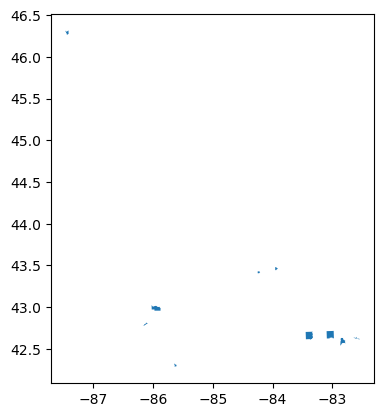

In [25]:
GDF_CDP[GDF_CDP["NAME"].isin(multi_match)].to_file(
    "./outputs/multi_match_cdp.geojson", driver="GeoJSON"
)
GDF_CDP[GDF_CDP["NAME"].isin(multi_match)].plot()

<Axes: >

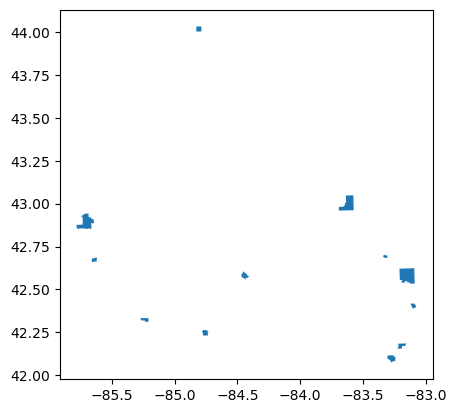

In [26]:
GDF_CITIES[GDF_CITIES["NAME"].isin(multi_match)].to_file(
    "./outputs/multi_match_city.geojson", driver="GeoJSON"
)
GDF_CITIES[GDF_CITIES["NAME"].isin(multi_match)].plot()

<Axes: >

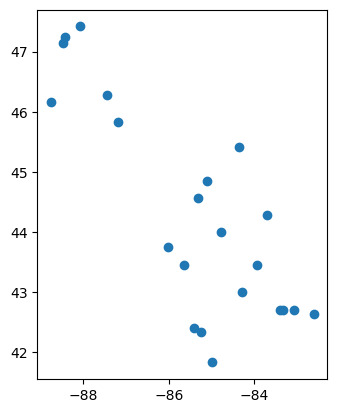

In [27]:
GDF_UNINCORP[GDF_UNINCORP["NAME"].isin(multi_match)].to_file(
    "./outputs/multi_match_unincorp.geojson", driver="GeoJSON"
)
GDF_UNINCORP[GDF_UNINCORP["NAME"].isin(multi_match)].plot()

<Axes: >

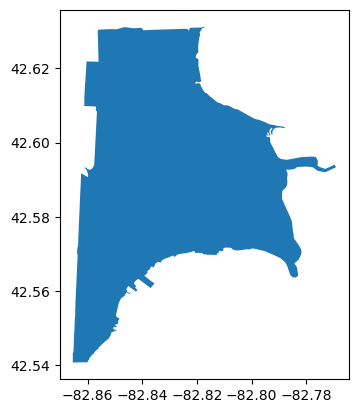

In [28]:
GDF_CDP[GDF_CDP["NAME"] == "Harrison"].plot()

# Conclusion

I think city and CDP data are the best match for these reasons:

- contiguous geographies unlike unincorp places
- CDP data includes census recognized unincorporated places
- Clear census data to merge on
- Only 1 match that occurs for both city and cdp
    - Harrison township is CDP and Harrison is City
- I run some tests below and find more Townships that have a name match when appending "Township" or "Twp" to the CDP name

But there remains ambiguous results with multiple matches and mismatched bounds. We will not continue with an analysis of this rate table, because we cannot with certainty match the correct demographic data to the insurance territories.

In [29]:
GDF_CDP["NAME_TOWNSHIP"] = GDF_CDP["NAME"] + " Township"
GDF_CDP["NAME_TWP"] = GDF_CDP["NAME"] + " Twp"
cdp_names = (
    list(GDF_CDP["NAME"]) + list(GDF_CDP["NAME_TOWNSHIP"]) + list(GDF_CDP["NAME_TWP"])
)
cdp_matches = loc_names[loc_names.isin(cdp_names)]
cdp_match_pct = prptn_to_pct(len(cdp_matches) / len(loc_names))
print(
    f"{cdp_match_pct}% of Progressive location names match to place name present in the city data"
)

5.3% of Progressive location names match to place name present in the city data


Example below including `Clinton` and `Clinton Township` indicate that Progressive is using the CDP bound and sub-geographies such as villages.

As well as mutually exclusive villages and cities with the same name such as Harrison city and Harrison Township as well as Shelby Township and Shelby village.

In [30]:
cdp_matches.sort_values()

164               Allendale
607                 Atlanta
44                 Au Sable
126               Beechwood
138                 Big Bay
159     Bloomfield Township
54               Bridgeport
205                    Burt
166            Byron Center
250          Canadian Lakes
257                  Canton
259              Canton Twp
717              Carrollton
845                 Clinton
794        Clinton Township
476           Comstock Park
335             Cutlerville
880                Freeland
417              Grosse Ile
500                   Gwinn
873                Harrison
523       Harrison Township
526                  Harvey
547                 Haslett
216                 Hemlock
177                    Holt
47            Houghton Lake
439                 Hubbell
82             Indian River
960                 Jenison
689            Lambertville
49                 Lewiston
141              Michigamme
764         Michigan Center
747                     Mio
474                N

# Merge demographics

In [31]:
CIY_CDP_RACE_DATA_FP = "../01_demographics/outputs/city_cdp_demographics.csv"
df = pd.read_csv(CIY_CDP_RACE_DATA_FP)
df

,geo_id,geo_name,tot_pop,white_tot,black_tot,aian_tot,asian_tot,nhopi_tot,other_tot,two_more_tot,latin_tot,white_pct,black_pct,aian_pct,asian_pct,nhopi_pct,other_pct,two_more_pct,latin_pct,median_income
0,2600380,"Addison village, Michigan",632,606,0,0,0,0,0,20,6,95.9,0.0,0.0,0.0,0.0,0.0,3.2,0.9,48403
1,2600440,"Adrian city, Michigan",20607,14478,726,0,56,12,0,871,4464,70.3,3.5,0.0,0.3,0.1,0.0,4.2,21.7,40797
2,2600480,"Advance CDP, Michigan",371,369,0,2,0,0,0,0,0,99.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,90833
3,2600620,"Ahmeek village, Michigan",87,79,0,0,0,0,0,0,8,90.8,0.0,0.0,0.0,0.0,0.0,0.0,9.2,55156
4,2600700,"Akron village, Michigan",330,279,3,2,1,0,0,22,23,84.5,0.9,0.6,0.3,0.0,0.0,6.7,7.0,55000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840,US88300,"Traverse City--Garfield, MI Urban Area (2020)",56071,51895,586,451,384,0,27,1506,1222,92.6,1.0,0.8,0.7,0.0,0.0,2.7,2.2,72195
841,US93214,"Wayland, MI Urban Area (2020)",4708,4134,222,0,57,0,0,111,184,87.8,4.7,0.0,1.2,0.0,0.0,2.4,3.9,61055
842,US94807,"Whitehall, MI Urban Area (2020)",8489,7084,58,13,103,0,21,378,832,83.4,0.7,0.2,1.2,0.0,0.2,4.5,9.8,65256
843,US95482,"Williamston, MI Urban Area (2020)",5100,4954,6,0,0,0,0,101,39,97.1,0.1,0.0,0.0,0.0,0.0,2.0,0.8,85504


In [32]:
df["geoid"] = df["geo_id"].str.slice(-5)

In [33]:
df = df[df["geoid"] != "00000"]
df = df[~(df["geoid"].duplicated(keep="first"))]

## City

In [34]:
GDF_CITIES["NAME"].isin(city_matches).sum()

257

In [35]:
gdf_cities_merge = GDF_CITIES[GDF_CITIES["NAME"].isin(city_matches)].merge(
    df, left_on="FIPSCODE", right_on="geoid", validate="1:1", how="left"
)
assert gdf_cities_merge["geoid"].isnull().sum() == 0

In [36]:
gdf_cities_merge

,OBJECTID,FIPSCODE,FIPSNUM,NAME,LABEL,TYPE,SQKM,SQMILES,ACRES,VER,...,white_pct,black_pct,aian_pct,asian_pct,nhopi_pct,other_pct,two_more_pct,latin_pct,median_income,geoid
0,1,82780,82780,Wakefield,City of Wakefield,City,21.851,8.437,5399.622,21,...,93.1,0.0,0.5,0.9,0.0,0.0,5.1,0.5,41837,82780
1,2,11400,11400,Buchanan,City of Buchanan,City,6.708,2.590,1657.650,21,...,83.0,5.9,0.0,0.6,0.0,0.5,7.7,2.3,53328,11400
2,3,61860,61860,Ovid,City of Ovid,City,2.692,1.039,665.182,21,...,83.7,0.6,0.0,0.0,0.0,0.0,8.0,7.7,49266,61860
3,4,86000,86000,Westland,City of Westland,City,52.924,20.434,13077.747,21,...,63.4,22.0,0.3,3.6,0.0,0.3,5.3,5.0,59930,86000
4,5,49000,49000,Livonia,City of Livonia,City,92.802,35.831,22931.898,21,...,83.5,4.4,0.1,3.6,0.0,0.5,3.5,4.3,92458,49000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,276,35580,35580,Grosse Pointe Woods,City of Grosse Pointe Woods,City,8.391,3.240,2073.575,21,...,88.2,5.6,0.0,0.8,0.0,0.3,3.0,2.2,125712,35580
253,277,59440,59440,Novi,City of Novi,City,81.000,31.274,20015.631,21,...,58.2,8.1,0.2,25.3,0.0,0.2,3.8,4.3,110588,59440
254,278,77860,77860,Sylvan Lake,City of Sylvan Lake,City,2.194,0.847,542.168,21,...,85.4,10.0,0.0,0.6,0.0,0.0,1.4,2.6,96900,77860
255,279,69260,69260,Rogers City,City of Rogers City,City,11.777,4.547,2910.241,21,...,95.3,0.4,0.0,0.8,0.0,0.5,2.8,0.3,53673,69260


## CDP

In [37]:
GDF_CDP["NAME"].isin(cdp_matches).sum() / len(GDF_CDP)

0.5263157894736842

In [38]:
gdf_cdp_merge = GDF_CDP[GDF_CDP["NAME"].isin(cdp_matches)].merge(
    df, left_on="FIPSCODE", right_on="geoid", validate="1:1", how="inner"
)

## Concat City and CDP

In [39]:
geography_demographics_columns = [
    "FIPSCODE",
    "FIPSNUM",
    "NAME",
    "LABEL",
    "TYPE",
    "SQMILES",
    "geometry",
    "geo_id",
    "geo_name",
    "tot_pop",
    "white_tot",
    "black_tot",
    "aian_tot",
    "asian_tot",
    "nhopi_tot",
    "other_tot",
    "two_more_tot",
    "latin_tot",
    "white_pct",
    "black_pct",
    "aian_pct",
    "asian_pct",
    "nhopi_pct",
    "other_pct",
    "two_more_pct",
    "latin_pct",
    "median_income",
    "geoid",
]

In [40]:
gdf_merge = pd.concat([gdf_cities_merge, gdf_cdp_merge])
gdf_merge = gdf_merge[geography_demographics_columns].copy()
gdf_merge.columns = [col.lower() for col in gdf_merge.columns]
gdf_merge

,fipscode,fipsnum,name,label,type,sqmiles,geometry,geo_id,geo_name,tot_pop,...,white_pct,black_pct,aian_pct,asian_pct,nhopi_pct,other_pct,two_more_pct,latin_pct,median_income,geoid
0,82780,82780,Wakefield,City of Wakefield,City,8.437,"POLYGON ((-89.98965 46.47740, -89.98967 46.477...",2682780,"Wakefield city, Michigan",1554,...,93.1,0.0,0.5,0.9,0.0,0.0,5.1,0.5,41837,82780
1,11400,11400,Buchanan,City of Buchanan,City,2.590,"POLYGON ((-86.38756 41.81327, -86.38658 41.813...",2611400,"Buchanan city, Michigan",4276,...,83.0,5.9,0.0,0.6,0.0,0.5,7.7,2.3,53328,11400
2,61860,61860,Ovid,City of Ovid,City,1.039,"POLYGON ((-84.36648 42.99077, -84.36650 42.992...",2661860,"Ovid city, Michigan",1445,...,83.7,0.6,0.0,0.0,0.0,0.0,8.0,7.7,49266,61860
3,86000,86000,Westland,City of Westland,City,20.434,"POLYGON ((-83.31283 42.35519, -83.31683 42.355...",2686000,"Westland city, Michigan",84806,...,63.4,22.0,0.3,3.6,0.0,0.3,5.3,5.0,59930,86000
4,49000,49000,Livonia,City of Livonia,City,35.831,"POLYGON ((-83.31683 42.44204, -83.31934 42.441...",2649000,"Livonia city, Michigan",94928,...,83.5,4.4,0.1,3.6,0.0,0.5,3.5,4.3,92458,49000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,37600,37600,Hemlock,Hemlock CDP,CDP,2.539,"POLYGON ((-84.24932 43.40655, -84.24130 43.406...",2637600,"Hemlock CDP, Michigan",1226,...,92.7,0.0,0.0,2.6,0.0,0.0,0.0,4.6,58787,37600
36,10440,10440,Bridgeport,Bridgeport CDP,CDP,8.411,"POLYGON ((-83.86697 43.35392, -83.86701 43.355...",2610440,"Bridgeport CDP, Michigan",6495,...,49.9,38.5,0.4,0.0,0.0,0.5,1.3,9.4,42719,10440
37,12000,12000,Burt,Burt CDP,CDP,4.519,"POLYGON ((-83.89101 43.22069, -83.88984 43.222...",2612000,"Burt CDP, Michigan",1271,...,91.9,0.0,0.0,0.0,0.0,0.0,8.1,0.0,82313,12000
38,63200,63200,Pearl Beach,Pearl Beach CDP,CDP,2.263,"POLYGON ((-82.56798 42.62197, -82.56918 42.622...",2663200,"Pearl Beach CDP, Michigan",5159,...,94.7,0.0,0.0,2.7,0.0,0.0,1.9,0.7,72490,63200


# Merge rating table

In [41]:
df_loc_terr_code = pd.read_csv("./outputs/loc_to_territory_m1_mappings.csv")
df_loc_terr_code

,Unnamed: 0.1,Unnamed: 0,territory_code,location_names
0,0,0,1,Addison Township
1,1,1,1,Buckley
2,2,2,1,Copemish
3,3,3,1,Lakeville
4,4,4,1,Manton
...,...,...,...,...
1059,1059,1059,388,Whitmore Lake
1060,1060,1060,389,Wolverine Lake
1061,1061,1061,390,Woodhaven
1062,1062,1062,391,Yale


In [42]:
df_auto_table = pd.read_csv("./outputs/progressive_auto.csv")
df_auto_table = df_auto_table.drop_duplicates()
df_auto_table

,company,vehicle_type,factor_circumvented,factor_name,geography_factor,geography_type,geography_factor_id,latitude,longitude,county_fips,...,rate_comp,rate_coll,rate_loan,rate_me_wl_acr,rate_um_uim,rate_rent,rate_tow,rate_acpe,rate_comp_trlr,rate_coll_trlr
0,Progressive,Auto,zip,Vehicle Garaging Location Factor,Territory Code,place_name,1,NaN,NaN,NaN,...,250,487,23,692,26,30,6,7,75,68
1,Progressive,Auto,zip,Vehicle Garaging Location Factor,Territory Code,place_name,2,NaN,NaN,NaN,...,170,319,16,647,25,20,4,5,51,45
2,Progressive,Auto,zip,Vehicle Garaging Location Factor,Territory Code,place_name,3,NaN,NaN,NaN,...,333,319,31,449,17,20,4,10,100,45
3,Progressive,Auto,zip,Vehicle Garaging Location Factor,Territory Code,place_name,4,NaN,NaN,NaN,...,86,349,8,586,22,22,4,2,26,49
4,Progressive,Auto,zip,Vehicle Garaging Location Factor,Territory Code,place_name,5,NaN,NaN,NaN,...,171,535,16,883,34,33,6,5,51,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,Progressive,Auto,zip,Vehicle Garaging Location Factor,Territory Code,place_name,388,NaN,NaN,NaN,...,137,297,13,472,18,18,3,4,41,42
388,Progressive,Auto,zip,Vehicle Garaging Location Factor,Territory Code,place_name,389,NaN,NaN,NaN,...,95,638,9,761,29,40,8,2,28,90
389,Progressive,Auto,zip,Vehicle Garaging Location Factor,Territory Code,place_name,390,NaN,NaN,NaN,...,131,556,12,1012,39,35,6,3,39,78
390,Progressive,Auto,zip,Vehicle Garaging Location Factor,Territory Code,place_name,391,NaN,NaN,NaN,...,372,315,35,746,28,19,3,11,112,44


In [43]:
gdf_merge_code = gdf_merge.merge(
    df_loc_terr_code,
    left_on="name",
    right_on="location_names",
    validate="1:1",
    how="left",
)
gdf_auto_merge = gdf_merge_code.merge(
    df_auto_table,
    left_on="territory_code",
    right_on="geography_factor_id",
    how="left",
    validate="m:1",
)

In [44]:
gdf_auto_merge.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 58 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   fipscode             297 non-null    object  
 1   fipsnum              297 non-null    int64   
 2   name                 297 non-null    object  
 3   label                297 non-null    object  
 4   type                 297 non-null    object  
 5   sqmiles              297 non-null    float64 
 6   geometry             297 non-null    geometry
 7   geo_id               297 non-null    object  
 8   geo_name             297 non-null    object  
 9   tot_pop              297 non-null    int64   
 10  white_tot            297 non-null    int64   
 11  black_tot            297 non-null    int64   
 12  aian_tot             297 non-null    int64   
 13  asian_tot            297 non-null    int64   
 14  nhopi_tot            297 non-null    int64   
 15  other_tot      